## 📘 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 📦 2. Load the Processed Data

In [2]:
train_df = pd.read_csv('../data/processed/train_encoded.csv')
test_df = pd.read_csv('../data/processed/test_encoded.csv', index_col='PassengerId')


## 🧹 3. Split Features & Target

In [3]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

## ✂️ 4. Train-Test Split
- Split off validation set from training data:

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S',
       'Embarked_C', 'Embarked_Q', 'Cabin_Deck_F', 'Cabin_Deck_C',
       'Cabin_Deck_E', 'Cabin_Deck_G', 'Cabin_Deck_D', 'Cabin_Deck_A',
       'Cabin_Deck_B', 'Cabin_Deck_T', 'FamilySize'],
      dtype='object')

In [6]:
test_df.columns

Index(['Unnamed: 0', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_Deck_A',
       'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D', 'Cabin_Deck_E',
       'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Deck_T'],
      dtype='object')

In [7]:
# reorder columns

X_train_columns = X_train.columns  # or a saved list of training columns

# Reorder test_df accordingly
test_df = test_df[X_train_columns]

## 🔄 5. Feature Scaling
- We scale only numeric features. Since you're using 1/-1 for categorical features, standardization won't impact them negatively.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_df)

## 🤖 6. Baseline Models to Try

You’ll experiment with at least **3–5 baseline models** to understand the data and evaluate performance.

| Model               | Use Case Description                                      |
|---------------------|-----------------------------------------------------------|
| **Logistic Regression** | Simple, interpretable model good for baseline comparisons |
| **Random Forest**       | Nonlinear, handles feature interactions and missing values |
| **XGBoost / LightGBM**  | Powerful tree-based ensemble methods, great for tabular data |
| **SVC (Support Vector Classifier)** | Margin-based classifier, useful for clear class boundaries |
| **KNN (K-Nearest Neighbors)** | Lazy learner, useful for distance-based similarity measures |

> 📊 You'll compare these using metrics like accuracy, precision, recall, F1-score, and ROC-AUC.


In [9]:
# 🧠 Python Helper Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store results in a list of dicts
model_results = []

def evaluate_model(model_name, y_true, y_pred):
    """
    Evaluate and log performance metrics for a classification model.
    
    Args:
        model_name (str): Name of the model (e.g., 'Logistic Regression')
        y_true (array): True labels
        y_pred (array): Predicted labels
    """
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    
    model_results.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    })


### ⚙️ 7. Model 1: Logistic Regression

Accuracy: 0.9497206703910615
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       110
           1       0.95      0.91      0.93        69

    accuracy                           0.95       179
   macro avg       0.95      0.94      0.95       179
weighted avg       0.95      0.95      0.95       179



<Axes: >

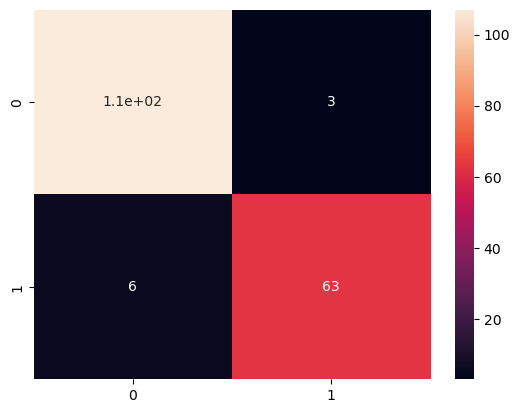

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_val_scaled)
# After training each model
evaluate_model('Logistic Regression', y_val, y_pred_lr)

# Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))
sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True)

### ⚙️ Model 2: Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

| Parameter           | Description                                               |
| ------------------- | --------------------------------------------------------- |
| `max_depth`         | Maximum tree depth (limits tree size)                     |
| `min_samples_split` | Minimum samples required to split a node                  |
| `min_samples_leaf`  | Minimum samples required at a leaf node                   |
| `max_leaf_nodes`    | Max number of terminal nodes                              |
| `ccp_alpha`         | Post-pruning cost complexity alpha (you can skip for now) |


In [12]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30]
}

#### . Grid Search with Cross-Validation

In [13]:
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'max_leaf_nodes': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


Best Parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       110
           1       0.85      0.88      0.87        69

    accuracy                           0.89       179
   macro avg       0.89      0.89      0.89       179
weighted avg       0.90      0.89      0.89       179



<Axes: >

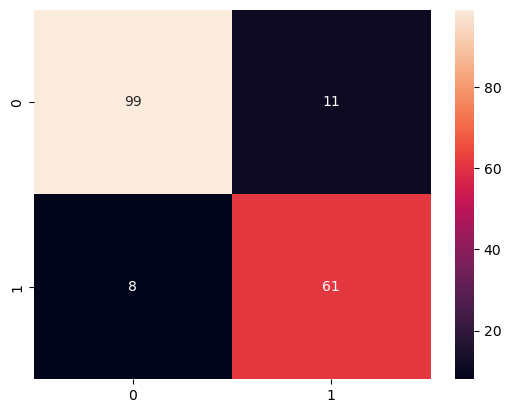

In [14]:
# best model

best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_val)

evaluate_model("Decision Tree", y_val, y_pred_dt)  # <- Your helper function
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred_dt))
sns.heatmap(confusion_matrix(y_val, y_pred_dt), annot=True)


#### Visualize the Decision Flow

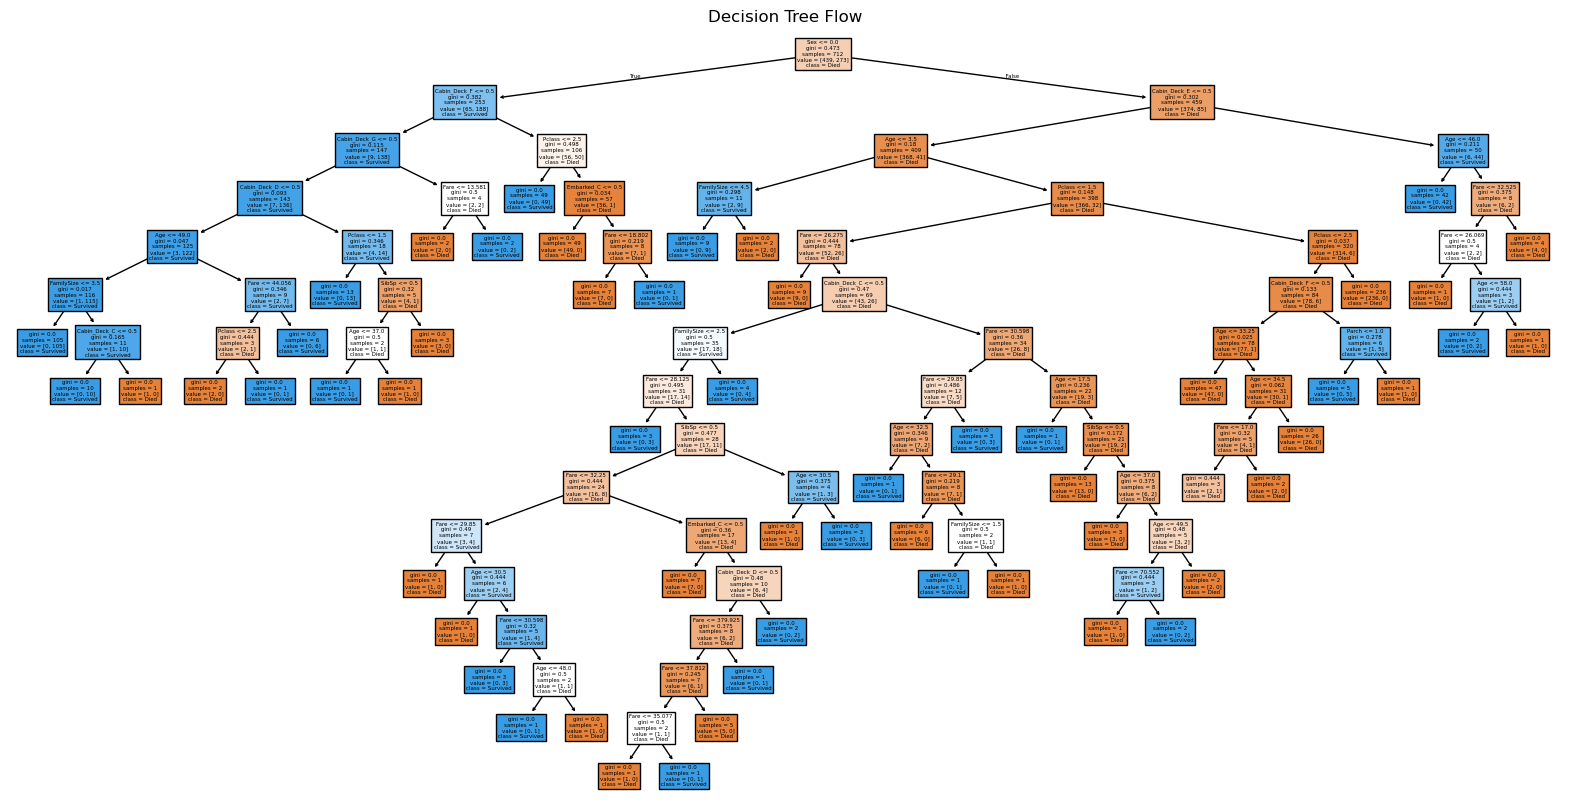

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_dt, filled=True, feature_names=X_train.columns, class_names=["Died", "Survived"])
plt.title("Decision Tree Flow")
plt.show()


In [16]:
### ⚙️ Model 3: Random Forest

| Parameter                  | Description                                                                                     | Default  |
| -------------------------- | ----------------------------------------------------------------------------------------------- | -------- |
| `n_estimators`             | Number of decision trees in the forest. Higher = better performance (up to a point).            | `100`    |
| `criterion`                | Function to measure the quality of a split. Use `"gini"` (default) or `"entropy"` (`log_loss`). | `"gini"` |
| `max_depth`                | Maximum depth of a tree. Limits complexity & helps prevent overfitting.                         | `None`   |
| `min_samples_split`        | Minimum number of samples required to split an internal node.                                   | `2`      |
| `min_samples_leaf`         | Minimum number of samples required to be at a leaf node.                                        | `1`      |
| `max_leaf_nodes`           | Maximum number of leaf nodes. Helps with pre-pruning.                                           | `None`   |
| `max_features`             | Number of features to consider when looking for the best split (`sqrt`, `log2`, or int/float).  | `"sqrt"` |
| `min_weight_fraction_leaf` | Similar to `min_samples_leaf` but uses fraction instead of count.                               | `0.0`    |


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       110
           1       0.90      0.90      0.90        69

    accuracy                           0.92       179
   macro avg       0.92      0.92      0.92       179
weighted avg       0.92      0.92      0.92       179



<Axes: >

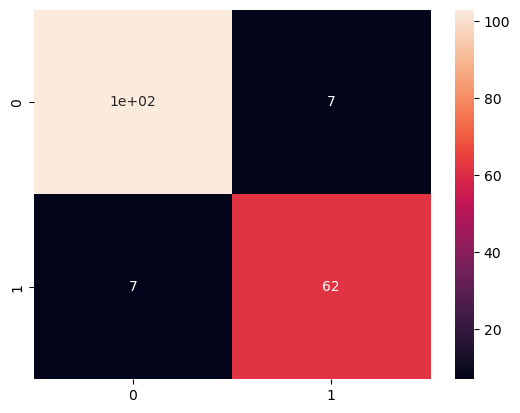

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


param_grid = {
    'n_estimators': [10,50,100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train,y_train)
best_rf = random_search.best_estimator_

y_pred_rf = best_rf.predict(X_val)
evaluate_model("Random Forest", y_val, y_pred_rf)  # <- Your helper function

print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred_rf))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True)


In [18]:
### ⚙️ Model 4: SVC

| Hyperparameter | Description | Typical Values | Impact |
|----------------|-------------|----------------|--------|
| `C`            | Regularization parameter. Controls trade-off between smooth decision boundary and correct classification of training points. | `0.01` to `100` | Smaller C → softer margin (allowing misclassifications); Larger C → harder margin (tries to classify all points correctly). |
| `kernel`       | Specifies the kernel type used in the algorithm. | `'linear'`, `'poly'`, `'rbf'`, `'sigmoid'` | Linear is faster; RBF handles complex boundaries; Poly adds interaction terms. |
| `degree`       | Degree of the polynomial kernel function (‘poly’ only). Ignored by other kernels. | `2`, `3`, `4`, `5` | Higher degree means more complex boundaries (only for `poly`). |
| `gamma`        | Kernel coefficient for `rbf`, `poly`, and `sigmoid`. | `'scale'`, `'auto'`, or float | Higher gamma → closer reach, more complex model; low gamma → broader influence. |
| `coef0`        | Independent term in kernel function (for `poly` and `sigmoid`). | `0.0` (default) | Affects the influence of higher-order vs lower-order terms. |
| `shrinking`    | Whether to use the shrinking heuristic. | `True` or `False` | `True` improves speed in many cases without loss in performance. |
| `probability`  | Whether to enable probability estimates via cross-validation. | `True` or `False` | Slower training but allows `predict_proba()` for ROC-AUC, etc. |
| `tol`          | Tolerance for stopping criteria. | `1e-3` or lower | Lower tol → more precise convergence but longer training. |
| `max_iter`     | Hard limit on iterations. `-1` means no limit. | `-1`, or positive integer | Can be useful to avoid long training time. |


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       110
           1       0.95      0.84      0.89        69

    accuracy                           0.92       179
   macro avg       0.93      0.91      0.92       179
weighted avg       0.92      0.92      0.92       179



<Axes: >

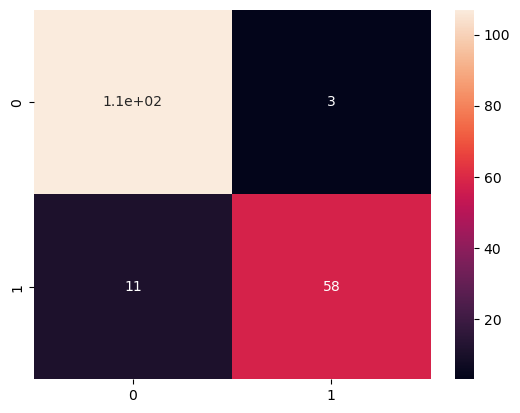

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# pipeline with Scaling + SVC, as SVC sensitive to feature scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10],                   # Regularization parameter
    'svc__kernel': ['linear', 'rbf', 'poly'], # Type of kernel
    'svc__gamma': ['scale', 'auto']           # Kernel coefficient
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_
y_pred_svc = best_svc.predict(X_val)
evaluate_model("SVC", y_val, y_pred_svc)  # <- Your helper function

print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred_svc))
sns.heatmap(confusion_matrix(y_val, y_pred_svc), annot=True)



In [20]:
### ⚙️ Model 5: KNN

| Hyperparameter | Description                                                   | Typical Range                                   |
| -------------- | ------------------------------------------------------------- | ----------------------------------------------- |
| `n_neighbors`  | Number of neighbors to use (K)                                | 1–30 (usually odd)                              |
| `weights`      | `'uniform'` (equal) or `'distance'` (closer = higher weight)  | `'uniform'`, `'distance'`                       |
| `algorithm`    | Algorithm used to compute neighbors                           | `'auto'`, `'ball_tree'`, `'kd_tree'`, `'brute'` |
| `p`            | Power parameter for distance (p=1: Manhattan, p=2: Euclidean) | 1 or 2                                          |
| `leaf_size`    | Affects tree algorithms' speed                                | 10–100                                          |


# ⚙️ Elbow Method to Find Optimal `k` in K-Nearest Neighbors (KNN)

The **Elbow Method** is a technique used to determine the optimal number of neighbors (`k`) for a KNN classifier. It helps avoid underfitting and overfitting by selecting the most balanced `k` value.

---

## ✅ Steps to Apply the Elbow Method

1. **Define a range of `k` values**, e.g., from 1 to 30.
2. **Loop through each `k` value**:
   - Train a KNN model using training data.
   - Predict on validation or test data.
   - Calculate the **error rate** (or 1 - accuracy).
3. **Plot the error rate** vs. `k`.
4. **Find the "elbow point"** — the value of `k` where error starts to plateau.  
   This is the ideal number of neighbors.

---

## 📈 Example Plot (Error vs. `k`)

```
k
│
│ ●
│  ●
│   ●
│    ●
│     ●
│       ●  
│         ● ●●●●●●→
└──────────────────────▶
Number of Neighbors (k)
```

The **elbow** is where the error rate flattens — typically after a steep decline.

---

## 💡 Tips

- Make sure to **standardize features** using `StandardScaler` or `MinMaxScaler`, since KNN is distance-based.
- Try both `weights='uniform'` and `weights='distance'` to see which performs better.
- Prefer **odd values of `k`** for binary classification to avoid prediction ties.
- Split your data into **train/validation** before applying the elbow method.


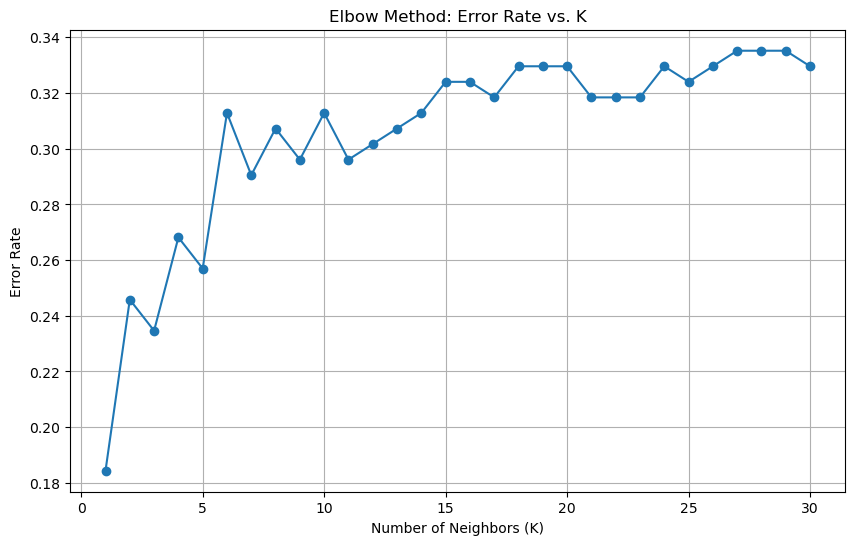

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

errors = []
k_range = range(1, 31)

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    error = 1 - accuracy_score(y_val, preds)
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(k_range, errors, marker='o')
plt.title('Elbow Method: Error Rate vs. K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()


## 📈 KNN Elbow Method – Interpretation of Error Trend

### 🔢 Observation Recap

| K (Neighbors) | Error Rate |
|---------------|------------|
| 1             | 0.18       |
| 2             | 0.25       |
| 10            | 0.30       |
| 25            | 0.35       |

---

### 🔍 What This Tells You

- **K = 1** gives the **lowest error**, which means it performs best on your validation/test set.
- As `k` increases, the model becomes more **biased** and **underfits** the data, resulting in higher error.
- **No distinct "elbow" point** is visible in this case — the curve is rising instead of flattening.

---

### 🧠 Insight

- This trend is **common in smaller or well-separated datasets** like Titanic.
- A **small `k` (1–3)** usually works better in such cases.
- **K = 1** is highly flexible but also **sensitive to noise**.
- To avoid overfitting, try using **K = 3** or **K = 5** for a better bias-variance trade-off.

---

### ✅ What You Can Do Next

1. **Test models with `k = 1`, `3`, and `5`**, and compare metrics like accuracy, precision, recall, and F1-score.
2. Optionally, apply **cross-validation** to validate that `k = 1` consistently performs well.
3. If you later increase dataset size or do feature engineering, **re-run the elbow plot** — the optimal `k` might change.

---

Let me know if you’d like to:
- Compare all metrics across selected `k` values
- Visualize KNN decision boundaries
- Or try other distance metrics (e.g., Manhattan, Minkowski)


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



<Axes: >

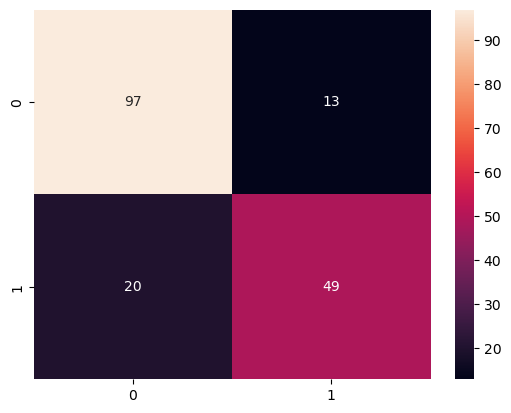

In [22]:
# fit with k=3

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)

y_pred_knn = knn.predict(X_val)

evaluate_model("KNN",y_val,y_pred_knn)

print(classification_report(y_val, y_pred_knn))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True)


## 🔍 Interpret Results 

In [23]:
model_results

[{'Model': 'Logistic Regression',
  'Accuracy': 0.9497,
  'Precision': 0.9545,
  'Recall': 0.913,
  'F1 Score': 0.9333},
 {'Model': 'Decision Tree',
  'Accuracy': 0.8939,
  'Precision': 0.8472,
  'Recall': 0.8841,
  'F1 Score': 0.8652},
 {'Model': 'Random Forest',
  'Accuracy': 0.9218,
  'Precision': 0.8986,
  'Recall': 0.8986,
  'F1 Score': 0.8986},
 {'Model': 'SVC',
  'Accuracy': 0.9218,
  'Precision': 0.9508,
  'Recall': 0.8406,
  'F1 Score': 0.8923},
 {'Model': 'KNN',
  'Accuracy': 0.8156,
  'Precision': 0.7903,
  'Recall': 0.7101,
  'F1 Score': 0.7481}]

In [24]:
# Convert to DataFrame and melt
df_results = pd.DataFrame(model_results)
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotly interactive bar chart
fig = px.bar(df_melted, 
             x='Model', 
             y='Score', 
             color='Metric', 
             barmode='group',
             text='Score',
             hover_data={'Score': ':.4f'})

fig.update_layout(
    title='Model Performance Comparison',
    yaxis=dict(range=[0, 1.05]),
    hovermode='x unified'
)

fig.show()

In [25]:
df_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.9497,0.9545,0.9130,0.9333
1,Decision Tree,0.8939,0.8472,0.8841,0.8652
2,Random Forest,0.9218,0.8986,0.8986,0.8986
3,SVC,0.9218,0.9508,0.8406,0.8923
4,KNN,0.8156,0.7903,0.7101,0.7481


## ✅ Insights

**Logistic Regression** is the best overall performer on your Titanic dataset.

### Why It's a Strong Choice:
- 🔍 **High interpretability** — easy to explain predictions
- ⚖️ **Balanced performance** across Accuracy, Precision, Recall, and F1 Score
- ⚡ **Fast training and prediction time**

---

## 🧠 Why This Makes Sense

The Titanic dataset appears to be **linearly separable enough**, especially with clearly informative features like:

- `Sex`
- `Pclass`
- `Fare`

In such cases, **Logistic Regression** performs well **without overfitting**, making it an excellent baseline model.

---

## 🔧 What’s Next?

1. 💾 **Save the Best Model**
   - Use `joblib` or `pickle` to save your logistic regression model for reuse.

2. 📤 **Submit to Kaggle**
   - Use `.to_csv()` on your test set predictions to prepare the submission file.

3. 🔍 **Optional: Model Interpretation**
   - Use tools like **SHAP** or **feature importance plots** to better understand what drives predictions.



## Make Predicitons on Test data

In [26]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q,Cabin_Deck_F,Cabin_Deck_C,Cabin_Deck_E,Cabin_Deck_G,Cabin_Deck_D,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_T,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,0,0,1,0,0,1,0,0,0,0,0,1
893,3,-1,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,0,0,2
894,2,1,62.0,0,0,9.6875,0,0,1,1,0,0,0,0,0,0,0,1
895,3,1,27.0,0,0,8.6625,1,0,0,0,0,1,0,0,0,0,0,1
896,3,-1,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,0,0,3


In [27]:
y_pred = lr.predict(test_df)
print(y_pred)
submission_df = pd.DataFrame({
    "PassengerId": test_df.index,
    "Survived": y_pred.astype(int)  # Ensure it's 0 or 1
})
submission_df.to_csv("..\outputs\submission.csv", index=False)



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


c:\Users\gunav\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

